# Separating solar surface features with Gaussian Mixture models

In [2]:
import numpy as np 

from matplotlib import pyplot as pl
from matplotlib import cm

from scipy import linalg
from sklearn import mixture

## 1. Load the data

In [7]:
input_data = "../../data/solar_surface_dataset_20170423.npz"


with np.load(input_data) as aa: 
    data_raw = aa["arr_0"]

for el in range(data.shape[1]):
    data[:, el] = data_raw[:, el] - np.mean(data_raw[:, el])
    data[:, el] = data_raw[:, el] / np.max(np.abs(data_raw[:, el]))

## 2. Preview of the data

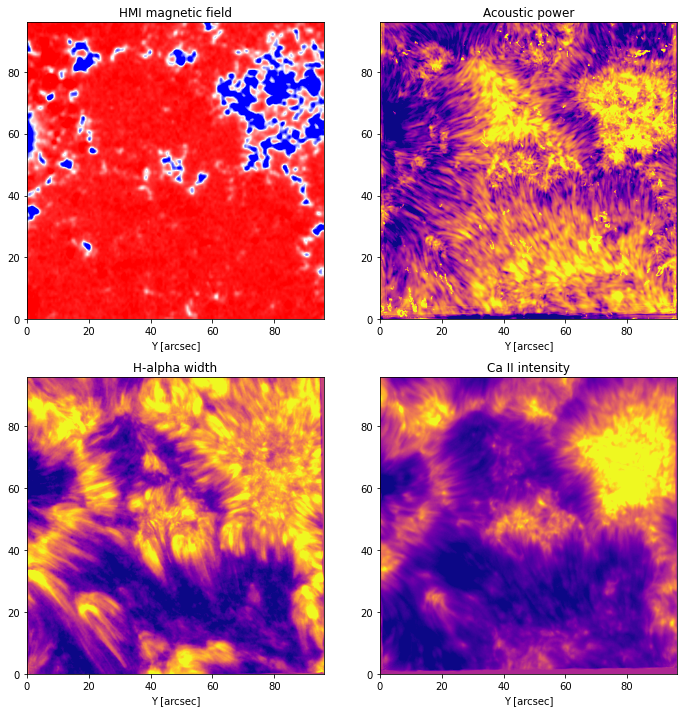

In [32]:
num_panels = 4 

fig, ax = pl.subplots(2, 2, figsize=(10, 10))

ax_flat = ax.flatten()

labels = ["HMI magnetic field", "Acoustic power", "H-alpha width", "Ca II intensity"]
extent = [0, 96, 0, 96]
cmaps = ["bwr", "plasma", "plasma", "plasma"]

for el in range(len(ax_flat)):
    ax_flat[el].imshow(data[:, el].reshape(1000, 1000), origin="0", extent=extent,
                       vmin=np.quantile(data[:, el], 0.04),
                       vmax=np.quantile(data[:, el], 0.96),
                       cmap=cmaps[el])
    ax_flat[el].set_title(labels[el])
    ax_flat[el].set_xlabel("X [arcsec]")
    ax_flat[el].set_xlabel("Y [arcsec]")
    
pl.tight_layout() 

## 3. Compute GMMs with the expectation minimization algorithm and BIC optimization

In [63]:
n_components_range = range(2, 14)
cv_types = ["full"]

bic = []
lowest_bic = np.infty

for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = mixture.GaussianMixture(n_components=n_components, 
                                      covariance_type=cv_type)
        gmm.fit(data)
        bic.append(gmm.bic(data[::30, :]))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            
bic = np.array(bic)

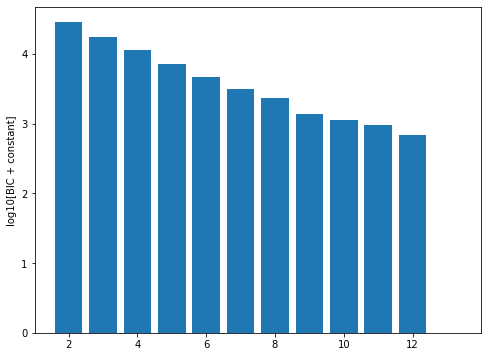

In [64]:
# plot the bic scores

pl.figure(figsize=(8, 6))
bic_a = bic -  np.amin(bic) + 1 #to make it positive
pl.bar(n_components_range, np.log10(bic_a))
pl.ylabel("log10[BIC + constant]")
pl.show() 

## 4. Compute Variational (Bayesian) GMMS with a Dirichlet generative process

In [ ]:
n_components = 10

dpgmm = mixture.BayesianGaussianMixture(n_components=n_components,
                                        weight_concentration_prior_type="dirichlet_distribution",
                                        weight_concentration_prior=0.001,
                                        mean_precision_prior=0.8,
                                        max_iter=10000,
                                        reg_covar=0, init_params="random").fit(data[::20, :])

In [ ]:
pl.bar(range(n_components),dpgmm.weights_)

In [ ]:
prediction = dpgmm.predict(data)

pl.figure(dpi=250)
im0 = pl.imshow(prediction.reshape(1000, 1000), origin="lower", cmap="tab10",
                extent=extent)
pl.colorbar(im0)

(1000000,)